Fitting model on a small sub-sample of the data
done in 0.160s.
Predicting color indices on the full image (k-means)
done in 0.083s.
Predicting color indices on the full image (random)
done in 0.068s.


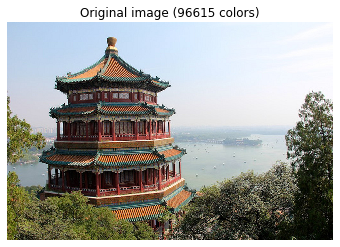

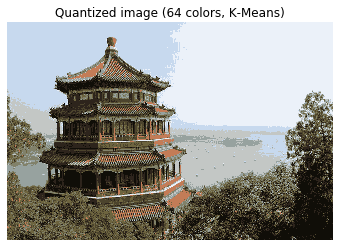

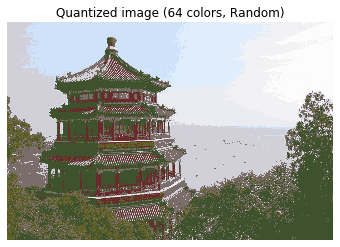

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time


n_colors = 10

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

china = np.array(china, dtype=np.float64) / 255 # 归一化处理(压缩到0-1)

w, h, d = original_shape = tuple(china.shape) # 图片的初始形状,china.shape=(图片的长度(纵轴像素点个数),图片的宽度,图片种中每个像素包含的特征数)
assert d == 3 # 断言,保证像素点的特征为3(像素点的颜色由像素点的特征(3个)组成)
image_array = np.reshape(china, (w * h, d)) # 由三维转换为二维矩阵 

init_color = np.unique(image_array, axis=0)

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000] # 随机抽取1000个像素点
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample) # 使用随机抽取的像素点进行KMeans
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array) # 由当初随机选取1000个像素点训练的KMeans来预测所有的像素点
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors] # 直接随机抽取64个像素点(可能有重复)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances(codebook_random,
                                   image_array).argmin(axis=0) # 按照随机抽取的像素点与所有像素点的距离来预测所有像素点
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """还原图片格式"""
    d = codebook.shape[1] # 像素点的特征数
    image = np.zeros((w, h, d)) # 图片的格式
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


# Display all results, alongside original image
plt.figure()
plt.axis('off')
plt.title('Original image (%d colors)' % init_color.shape[0])
plt.imshow(china)

# 将显示图像所需的颜色数量从96,615种独特颜色减少到64种.采用KMeans
plt.figure()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# 将显示图像所需的颜色数量从96,615种独特颜色减少到64种.采用随机抽取
plt.figure()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

